<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/deploy_model_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Lib

We'll be using those libraries:

1. [Watson Machine Learning Client](http://wml-api-pyclient.mybluemix.net/): Client library to work with the Watson Machine Learning service on IBM Cloud.
1. [Pixiedust](https://github.com/pixiedust/pixiedust): Python Helper library for Jupyter Notebooks
1. [ibmos2spark](https://github.com/ibm-watson-data-lab/ibmos2spark): Facilitates Data I/O between Spark and IBM Object Storage services

In [0]:
!pip install --upgrade ibmos2spark
!pip install --upgrade pixiedust
!pip install --upgrade watson-machine-learning-client

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191022200129-0000
KERNEL_ID = 10c23acb-988c-4444-9c85-6f186ae992b7
    100% |################################| 204kB 4.1MB/s eta 0:00:01
    100% |################################| 798kB 2.7MB/s eta 0:00:01
    100% |################################| 5.8MB 1.9MB/s eta 0:00:01
    100% |################################| 92kB 2.1MB/s eta 0:00:01
    100% |################################| 61kB 1.8MB/s eta 0:00:01
    100% |################################| 583kB 4.7MB/s eta 0:00:01
    100% |################################| 133kB 4.7MB/s eta 0:00:01
    100% |################################| 143kB 4.6MB/s eta 0:00:01
    100% |################################| 61kB 2.9MB/s eta 0:00:01
    100% |################################| 163kB 4.8MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Stored in directory: /hom

    100% |################################| 512kB 4.6MB/s eta 0:00:01
    100% |################################| 20.0MB 1.0MB/s eta 0:00:01
    100% |################################| 235kB 5.2MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/14/2c/cd551d81dbe15200be1cf41cd03869a46fe7226e7450af7a6545bfc474c9/idna-2.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
    100% |################################| 757kB 3.2MB/s eta 0:00:01
    100% |################################| 143kB 5.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
    100% |################################| 552kB 4.9MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac4717

# Load data

In [0]:
import ibmos2spark
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-e5857043-ddb4-49a1-81b0-d00a29224da0',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': ''
}

configuration_name = 'os_3b5d6725d31e421f902328ed36b65f14_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema','True')\
  .load(cos.url('rf_data.csv', 'predictincomepotential-donotdelete-pr-tg55qtqcmgw2hz'))
df_data.take(2)


[Row(_c0=0, age=39, workclass='state-gov', final_weight=77516, education_duration=13, marital_status='never-married', occupation='adm-clerical', relationship='not-in-family', race='white', sex='male', capital_gain=2174, capital_loss=0, hours_per_week=40, native_country='united-states', has_missing_values=0, com_workclass='government', com_marital_status='never-married', com_native_country='north_america', age final_weight=3023124.0, age education_duration=507.0, age hours_per_week=1560.0, age capital_gain=84786.0, age capital_loss=0.0, final_weight education_duration=1007708.0, final_weight hours_per_week=3100640.0, final_weight capital_gain=168519784.0, final_weight capital_loss=0.0, education_duration hours_per_week=520.0, education_duration capital_gain=28262.0, education_duration capital_loss=0.0, hours_per_week capital_gain=86960.0, hours_per_week capital_loss=0.0, target=0),
 Row(_c0=1, age=50, workclass='self-emp-not-inc', final_weight=83311, education_duration=13, marital_statu

In [0]:
from project_lib import Project
import numpy as np
project = Project(spark.sparkContext, '', '')
pc = project.project_context

# Fetch the file
my_file = project.get_file("features.pkl.npy")

features = list(np.load(my_file))

# Clean data

In [0]:
df_data = df_data.drop('_c0')

In [0]:
df = df_data.drop('native_country')
df = df.withColumn("has_missing_values1", df.has_missing_values.cast('string'))
df =df.drop("has_missing_values").withColumnRenamed("has_missing_values1", "has_missing_values")

df = df.withColumn("target1", df.target.cast('string'))
df = df.drop("target").withColumnRenamed("target1", "target")

In [0]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- final_weight: integer (nullable = true)
 |-- education_duration: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- com_workclass: string (nullable = true)
 |-- com_marital_status: string (nullable = true)
 |-- com_native_country: string (nullable = true)
 |-- age final_weight: double (nullable = true)
 |-- age education_duration: double (nullable = true)
 |-- age hours_per_week: double (nullable = true)
 |-- age capital_gain: double (nullable = true)
 |-- age capital_loss: double (nullable = true)
 |-- final_weight education_duration: double (nullable = true)
 |-- final_weight hours_pe

# Create a Spark machine learning model

### 4.1 Prepare data

In [0]:
split_data = df.randomSplit([0.8, 0.20], 24)
train_data = split_data[0]
test_data = split_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 38993
Number of testing records : 9820


# Create pipeline and train a model

In this section we will create a Spark machine learning pipeline and then train the model. In the first step we need to import the Spark machine learning packages that will be needed in the subsequent steps. A sequence of data processing is called a _data pipeline_. Each step in the pipeline processes the data and passes the result to the next step in the pipeline, this allows you to transform and fit your model with the raw input data.

In [0]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [0]:
stringIndexer_label = StringIndexer(inputCol="target", outputCol="label").fit(df)

In the following step, convert all the string fields to numeric ones by using the StringIndexer transformer.

In [0]:
stringIndexer_workclass = StringIndexer(inputCol="workclass", outputCol="workclass_lbl")
stringIndexer_marital_status = StringIndexer(inputCol="marital_status", outputCol="marital_status_lbl")
stringIndexer_occupation = StringIndexer(inputCol="occupation", outputCol="occupation_lbl")
stringIndexer_relationship = StringIndexer(inputCol="relationship", outputCol="relationship_lbl")
stringIndexer_race = StringIndexer(inputCol="race", outputCol="race_lbl")
stringIndexer_sex = StringIndexer(inputCol="sex", outputCol="sex_lbl")
stringIndexer_has_missing_values = StringIndexer(inputCol = 'has_missing_values', outputCol = 'has_missing_values_lbl')
stringIndexer_com_workclass = StringIndexer(inputCol = 'com_workclass', outputCol = 'com_workclass_lbl')
stringIndexer_com_marital_status = StringIndexer(inputCol = 'com_marital_status', outputCol = 'com_marital_status_lbl')
stringIndexer_com_native_country = StringIndexer(inputCol = 'com_native_country', outputCol = 'com_native_country_lbl')

In [0]:
cat_features = [
 'workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'has_missing_values',
 'com_workclass',
 'com_marital_status',
 'com_native_country',]
feats = df.columns
if 'target' in feats: feats.remove('target')

In [0]:
cont_features = list(set(feats).difference(set(cat_features)))
all_feat = [feat + '_lbl' for feat in cat_features] + cont_features

In [0]:
vectorAssembler_features = VectorAssembler(inputCols = all_feat, outputCol="features")

Next, define estimators you want to use for classification. Random Forest is used in the following example.

In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, indexed labels back to original labels.

In [0]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

Let's build the pipeline now. A pipeline consists of transformers and an estimator.

In [0]:
pipeline_rf = Pipeline(stages=[stringIndexer_label,
                                         stringIndexer_workclass,
                                         stringIndexer_marital_status,
                                         stringIndexer_occupation,
                                         stringIndexer_relationship,
                                         stringIndexer_race,
                                         stringIndexer_sex,
                                        stringIndexer_has_missing_values,
                                        stringIndexer_com_workclass,
                                        stringIndexer_com_marital_status,
                                        stringIndexer_com_native_country,
                                          vectorAssembler_features,
                               rf, labelConverter])

Now, we can train your Random Forest model by using the previously defined **pipeline** and **training data**.

In [0]:
model_rf = pipeline_rf.fit(train_data)

# Model Evaluation

In [0]:
train_predictions = model_rf.transform(train_data)
test_predictions = model_rf.transform(test_data)

In [0]:
Xy_train = train_data.toPandas()
Xy_test = test_data.toPandas()

In [0]:
X_train, y_train = Xy_train.drop(columns = 'target'), Xy_train[['target']]
X_test, y_test = Xy_test.drop(columns = 'target'), Xy_test[['target']]

In [0]:
y_train_hat = train_predictions.select('prediction', 'predictedLabel').toPandas()
y_test_hat = test_predictions.select('prediction', 'predictedLabel').toPandas()

In [0]:
y_train.loc[:, 'target'] = y_train.loc[:, 'target'].astype(int)
y_test.loc[:, 'target'] = y_test.loc[:, 'target'].astype(int)
y_train_hat = y_train_hat['prediction']
y_test_hat = y_test_hat['prediction']

/home/spark/shared/user-libs/python3.6/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [0]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
tr_acc = accuracy_score(y_train, y_train_hat)
tr_f1 = f1_score(y_train, y_train_hat)
tr_auc = roc_auc_score(y_train, y_train_hat)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
test_auc = roc_auc_score(y_test, y_test_hat)
print('------train-----------')
print('accuracy_score: ', tr_acc)
print('f1_score: ', tr_f1)
print('roc_auc_score: ', tr_auc)
print('------test-------------')
print('accuracy_score: ', test_acc)
print('f1_score: ', test_f1)
print('roc_auc_score: ', test_auc)

------train-----------
accuracy_score:  0.851050188495371
f1_score:  0.6397022332506204
roc_auc_score:  0.7478433278433532
------test-------------
accuracy_score:  0.8539714867617108
f1_score:  0.6317411402157166
roc_auc_score:  0.7439425958402399


[[7127  407]
 [1019 1267]]


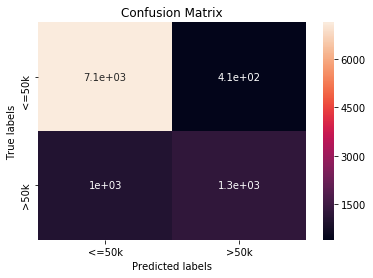

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
labels = [0, 1]
cm = confusion_matrix(y_test, y_test_hat, labels)
print(cm)
ax =  plt.subplot()
sns.heatmap(cm, annot = True, ax = ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['<=50k', '>50k']); 
ax.yaxis.set_ticklabels(['<=50k', '>50k']);

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7534
           1       0.76      0.55      0.64      2286

   micro avg       0.85      0.85      0.85      9820
   macro avg       0.82      0.75      0.77      9820
weighted avg       0.85      0.85      0.85      9820



# Persist model


In [0]:
wml_credentials = {
  "apikey": "",
  "iam_apikey_description": "",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "",
  "instance_id": "de9133b0-3524-4add-a7ed-258f25382a48",
  "url": "https://us-south.ml.cloud.ibm.com"
}

In [0]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

1.0.375


Reason: 'NoneType' object has no attribute 'groups'


Create model artifact (abstraction layer).

In [0]:
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Bassel Kassem", 
               client.repository.ModelMetaNames.NAME: "predict_income_potential_Model"}
published_model = client.repository.store_model(model=model_rf, pipeline=pipeline_rf, meta_props=model_props, training_data=train_data)


## Save pipeline and model

In this subsection you will learn how to save pipeline and model artifacts to your Watson Machine Learning instance.

In [0]:
import json
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

# Accessing Watson ML Models and Deployments through API

Instead of jumping from your notebook into a web browser, manage your model and delopment through a set of APIs

### Deploy model to WML Service

In [0]:
created_deployment = client.deployments.create(published_model_uid, name="predict_income_potential")



#######################################################################################

Synchronous deployment creation for uid: '72356087-ffae-4dee-95f6-816ec6d14674' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4144e5b8-66a1-449b-89b1-d9c459c57810'
------------------------------------------------------------------------------------------------




### Print the scoring endpoint

In [0]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/de9133b0-3524-4add-a7ed-258f25382a48/deployments/4144e5b8-66a1-449b-89b1-d9c459c57810/online


## 6.1 Invoke prediction model deployment


In [0]:
sample = X_test.tail(1)
sample

,age,workclass,final_weight,education_duration,marital_status,occupation,relationship,race,sex,capital_gain,...,final_weight education_duration,final_weight hours_per_week,final_weight capital_gain,final_weight capital_loss,education_duration hours_per_week,education_duration capital_gain,education_duration capital_loss,hours_per_week capital_gain,hours_per_week capital_loss,has_missing_values
9819,90,self-emp-not-inc,122348,15,married-civ-spouse,prof-specialty,husband,white,male,20051,...,1835220.0,5505660.0,2.453200e+09,0.0,675.0,300765.0,0.0,902295.0,0.0,0


In [0]:
scoring_payload = { "fields": list(sample.columns.values),"values":[list(sample.values[0])]}
print(scoring_payload)

{'fields': ['age', 'workclass', 'final_weight', 'education_duration', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'com_workclass', 'com_marital_status', 'com_native_country', 'age final_weight', 'age education_duration', 'age hours_per_week', 'age capital_gain', 'age capital_loss', 'final_weight education_duration', 'final_weight hours_per_week', 'final_weight capital_gain', 'final_weight capital_loss', 'education_duration hours_per_week', 'education_duration capital_gain', 'education_duration capital_loss', 'hours_per_week capital_gain', 'hours_per_week capital_loss', 'has_missing_values'], 'values': [[90, 'self-emp-not-inc', 122348, 15, 'married-civ-spouse', 'prof-specialty', 'husband', 'white', 'male', 20051, 0, 45, 'self-employed', 'married-civ-spouse', 'north_america', 11011320.0, 1350.0, 4050.0, 1804590.0, 0.0, 1835220.0, 5505660.0, 2453199748.0, 0.0, 675.0, 300765.0, 0.0, 902295.0, 0.0, '0']]}


In [0]:
predictions = client.deployments.score(scoring_endpoint, scoring_payload)
print(json.dumps(predictions, indent=2))
print(predictions['values'][0][30])

{
  "fields": [
    "age",
    "workclass",
    "final_weight",
    "education_duration",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "com_workclass",
    "com_marital_status",
    "com_native_country",
    "age final_weight",
    "age education_duration",
    "age hours_per_week",
    "age capital_gain",
    "age capital_loss",
    "final_weight education_duration",
    "final_weight hours_per_week",
    "final_weight capital_gain",
    "final_weight capital_loss",
    "education_duration hours_per_week",
    "education_duration capital_gain",
    "education_duration capital_loss",
    "hours_per_week capital_gain",
    "hours_per_week capital_loss",
    "has_missing_values",
    "target",
    "label",
    "workclass_lbl",
    "marital_status_lbl",
    "occupation_lbl",
    "relationship_lbl",
    "race_lbl",
    "sex_lbl",
    "has_missing_values_lbl",
    "com_workclass_lbl",
   

### Narrow down prediction results to just the prediction

In [0]:
print('Am I going to earn more than 50k? {}'.format(client.deployments.score(scoring_endpoint, scoring_payload)
['values'][0][46]))

Am I going to earn more than 50k? 0
